In [159]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import copy

import scoobpsf
import scoobpsf.ad_scoob as ad_scoob
import scoobpsf.props as props
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3

import lina

from importlib import reload

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle

from scipy.signal import windows
from scipy.optimize import minimize

wavelength = 650e-9*u.m
pupil_diam = 9.4*u.mm
lyot_stop_diam = 8.6*u.mm
scc_sep = 5.5*u.mm

crad = 34/2 * 9.4/10.2 * 8.6/9.4

def create_control_mask(iwa=3, owa=12, edge=None, rotation=0):
    x = (xp.linspace(-npsf/2, npsf/2-1, npsf) + 1/2)*psf_pixelscale_lamD
    x,y = xp.meshgrid(x,x)
    r = xp.hypot(x, y)
    control_mask = (r < owa) * (r > iwa)
    if edge is not None: control_mask *= (x > edge)

    control_mask = _scipy.ndimage.rotate(control_mask, rotation, reshape=False, order=0)
    return control_mask

# Establish the forward model parameters.

916


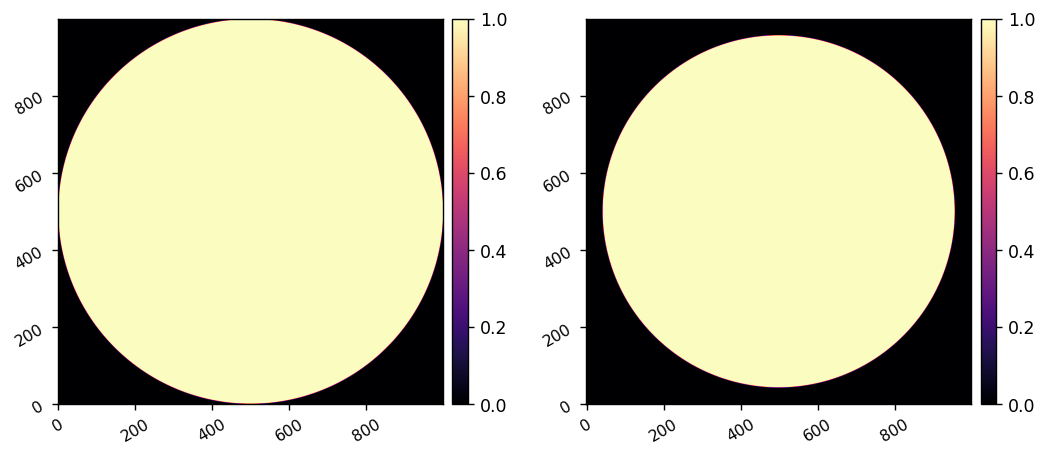

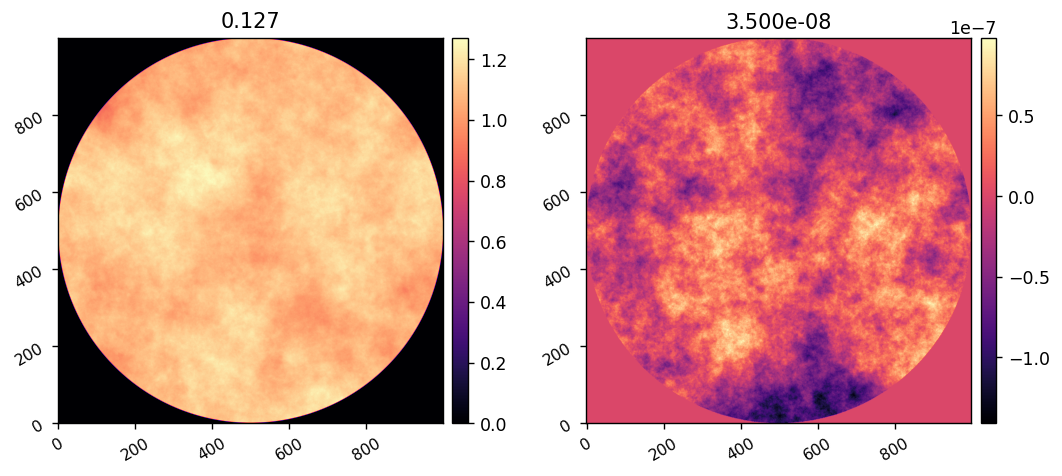

In [157]:
npix = 1000
oversample = 2.048
N = int(npix*oversample)

nlyot = int(np.ceil(lyot_stop_diam/pupil_diam * npix))
if nlyot%2==1:
    nlyot += 1
print(nlyot)

import poppy
pwf = poppy.FresnelWavefront(beam_radius=pupil_diam/2, npix=npix, oversample=1) # pupil wavefront
APERTURE = poppy.CircularAperture(radius=pupil_diam/2).get_transmission(pwf)
LYOT = poppy.CircularAperture(radius=lyot_stop_diam/2).get_transmission(pwf)
imshow2(APERTURE, LYOT)

reload(utils)
WFE, mask = utils.generate_wfe(diam=pupil_diam,
                                npix=npix, oversample=1,
                                wavelength=wavelength,
                                opd_index=2.75, amp_index=3,
                                opd_rms=35*u.nm, amp_rms=0.05,
                                # opd_seed=12, amp_seed=1234,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*wavelength.to_value(u.m)/2/np.pi
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')

### Initialize DM parameters

31.914893617021274
1148


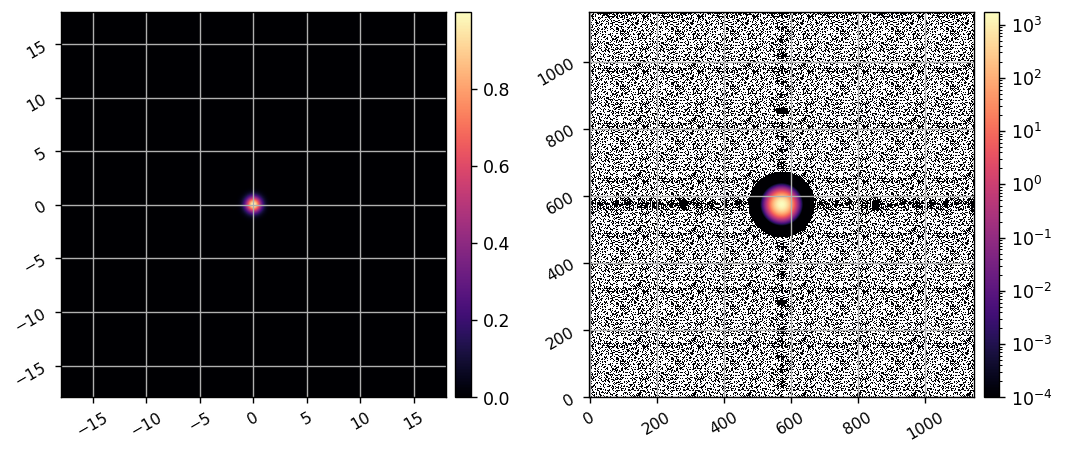

952


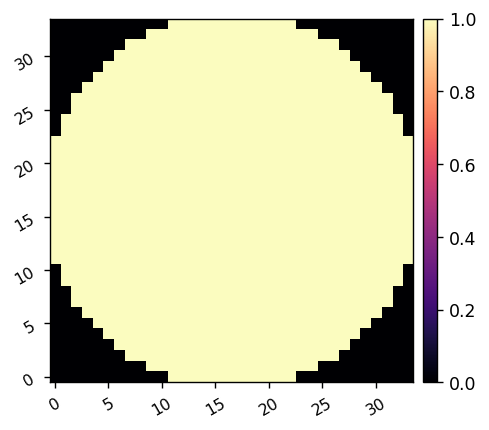

In [158]:
Nact = 34
act_spacing = 0.3*u.mm
inf_sampling = (npix/pupil_diam * act_spacing).value
print(inf_sampling)

reload(ad_scoob)
inf_fun = ad_scoob.make_gaussian_inf_fun(act_spacing=act_spacing, sampling=inf_sampling, 
                                         Nacts_per_inf=Nact + 2, # number of influence functions across the grid
                                         coupling=0.15,)

Nsurf = inf_fun.shape[0]
print(Nsurf)

fourier_inf_fun = xp.fft.fft2(inf_fun)
imshow2(inf_fun, xp.abs(xp.fft.fftshift(fourier_inf_fun)), pxscl1=1/inf_sampling, grid=True, lognorm2=True, vmin2=1e-4)

# DM command coordinates
xc = inf_sampling*(xp.linspace(-Nact//2, Nact//2-1, Nact) + 1/2)
yc = inf_sampling*(xp.linspace(-Nact//2, Nact//2-1, Nact) + 1/2)

dm_mask = xp.ones((Nact,Nact), dtype=bool)
xx = (xp.linspace(-Nact//2, Nact//2 - 1, Nact) + 1/2)
x,y = xp.meshgrid(xx,xx)
r = xp.sqrt(x**2 + y**2)
dm_mask[r>(Nact/2 + 1/2)] = 0
Nacts = int(xp.sum(dm_mask))
print(Nacts)
imshow1(dm_mask)

# Influence function frequncy sampling
fx = xp.fft.fftfreq(Nsurf)
fy = xp.fft.fftfreq(Nsurf)

# forward DM model MFT matrices
Mx_dm = xp.exp(-1j*2*np.pi*xp.outer(fx,xc))
My_dm = xp.exp(-1j*2*np.pi*xp.outer(yc,fy))

Mx_dm_back = xp.exp(1j*2*np.pi*xp.outer(xc,fx))
My_dm_back = xp.exp(1j*2*np.pi*xp.outer(fy,yc))

### Initialize vortex mask parameters.

In [29]:
N_vortex_hres

1200

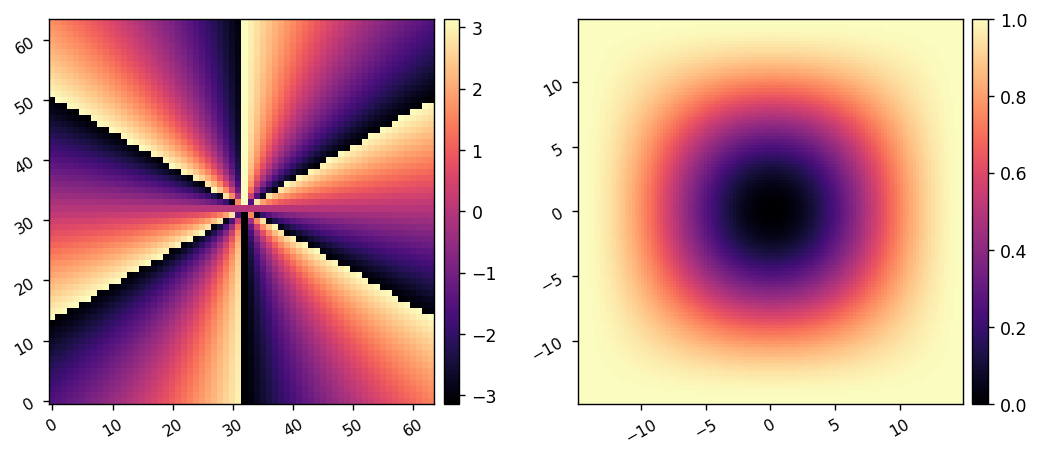

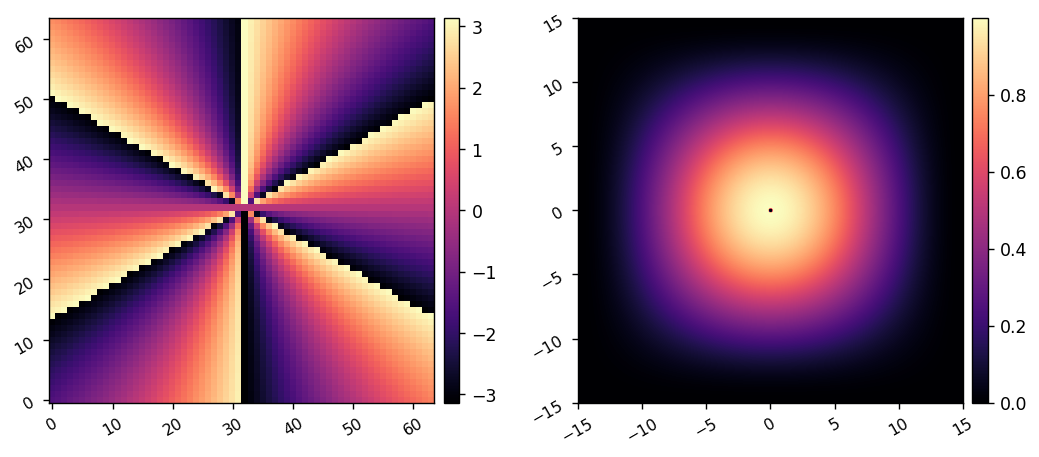

In [41]:
oversample_vortex = 4.096
N_vortex_lres = int(npix*oversample_vortex)
lres_sampling = 1/oversample_vortex # low resolution sampling in lam/D per pixel
lres_win_size = int(30/lres_sampling)
w1d = xp.array(windows.tukey(lres_win_size, 1, False))
lres_window = utils.pad_or_crop(xp.outer(w1d, w1d), N_vortex_lres)
vortex_lres = props.make_vortex_phase_mask(N_vortex_lres)
imshow2(xp.angle(vortex_lres), 1-lres_window, npix1=64, npix2=lres_win_size, pxscl2=lres_sampling)

hres_sampling = 0.025 # lam/D per pixel; this value is chosen empirically
N_vortex_hres = int(np.round(30/hres_sampling))
hres_win_size = int(30/hres_sampling)
w1d = xp.array(windows.tukey(hres_win_size, 1, False))
hres_window = utils.pad_or_crop(xp.outer(w1d, w1d), N_vortex_hres)
vortex_hres = props.make_vortex_phase_mask(N_vortex_hres)

x = (xp.linspace(-N_vortex_hres//2, N_vortex_hres//2-1, N_vortex_hres)) * hres_sampling
x,y = xp.meshgrid(x,x)
r = xp.sqrt(x**2 + y**2)
sing_mask = r>0.15
hres_window *= sing_mask
imshow2(xp.angle(vortex_hres), hres_window, npix1=64, npix2=hres_win_size, pxscl2=hres_sampling)

psf_pixelscale_lamD = 0.17
npsf = 200

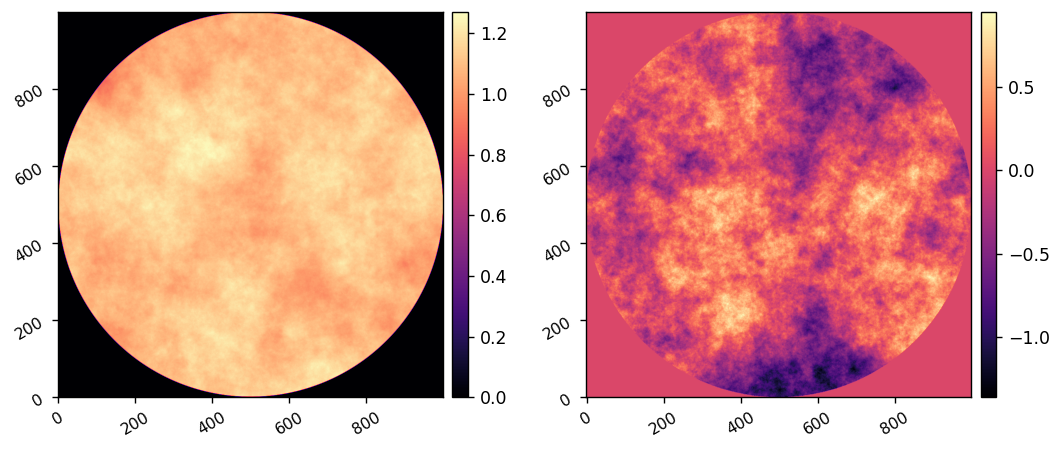

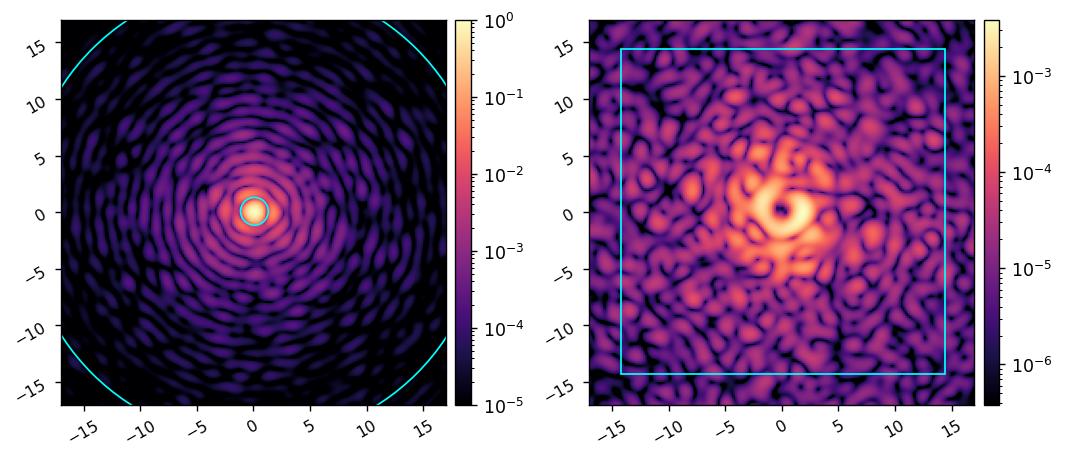

In [42]:
def forward_model(actuators, use_vortex=True, use_wfe=True, return_pupil=False):
    actuators = xp.array(actuators)
    command = xp.zeros((Nact,Nact))
    command[dm_mask] = actuators
    mft_command = Mx_dm@command@My_dm
    fourier_surf = fourier_inf_fun * mft_command
    dm_surf = xp.fft.ifft2(fourier_surf).real

    dm_phasor = xp.exp(1j * 4*xp.pi/wavelength.to_value(u.m) * dm_surf)
    wf = utils.pad_or_crop(APERTURE, N).astype(xp.complex128)
    
    wf *= utils.pad_or_crop(dm_phasor, N)
    # imshow2(xp.abs(wf), xp.angle(wf), npix=npix)

    if use_wfe: 
        wf *= utils.pad_or_crop(WFE, N)
        # imshow2(xp.abs(wf), xp.angle(wf), npix=npix)

    if return_pupil:
        E_pup = copy.copy(wf)

    if use_vortex:
        lres_wf = utils.pad_or_crop(wf, N_vortex_lres) # pad to the larger array for the low res propagation
        fp_wf_lres = xp.fft.ifftshift(xp.fft.fft2(xp.fft.fftshift(lres_wf))) # to FPM
        fp_wf_lres *= vortex_lres * (1 - lres_window) # apply low res (windowed) FPM
        pupil_wf_lres = xp.fft.fftshift(xp.fft.ifft2(xp.fft.ifftshift(fp_wf_lres))) # to Lyot Pupil
        # pupil_wf_lres = utils.pad_or_crop(pupil_wf_lres, N)

        hres_wf = utils.pad_or_crop(wf, npix) # crop to the pupil diameter for the high res propagation
        fp_wf_hres = props.mft_forward(hres_wf, hres_sampling, N_vortex_hres)
        fp_wf_hres *= vortex_hres * hres_window # apply high res (windowed) FPM
        # pupil_wf_hres = props.mft_reverse(fp_wf_hres, hres_sampling, npix,)
        # pupil_wf_hres = utils.pad_or_crop(pupil_wf_hres, N)
        pupil_wf_hres = props.mft_reverse(fp_wf_hres, hres_sampling*oversample_vortex, N_vortex_lres,)

        wf = (pupil_wf_lres + pupil_wf_hres)
        wf = utils.pad_or_crop(wf, N)
        # imshow2(xp.abs(wf)**2, xp.angle(wf), lognorm1=True)

    wf *= utils.pad_or_crop(LYOT, N)
    # imshow2(xp.abs(wf), xp.angle(wf), npix=2*npix)

    wf = utils.pad_or_crop(wf, nlyot)
    fpwf = props.mft_forward(wf, psf_pixelscale_lamD, npsf)

    if return_pupil:
        return fpwf, E_pup
    else:
        return fpwf

acts = np.zeros(Nacts)

waffle_command = 10e-9 * xp.ones((Nact,Nact))
waffle_command[1::2, ::2] *= -1
waffle_command[::2, 1::2] *= -1
# acts = ensure_np_array(waffle_command[dm_mask]) 

# waffle_command = 10e-9 * xp.ones((Nact,Nact))
# waffle_command[::2,::2] *= -1
# waffle_command[1::2, 1::2] = 0
# acts = ensure_np_array(waffle_command[dm_mask]) 

print()
psf_wf, E_pup = forward_model(acts, 
                                use_vortex=False, 
                                #    use_wfe=False, 
                                return_pupil=True,
                                )
coro_wf = forward_model(acts, 
                        # use_wfe=False,
                        )


psf = xp.abs(psf_wf)**2 
coro_im = xp.abs(coro_wf)**2
I_max_ref = xp.max(psf)

psf /= I_max_ref
coro_im /= I_max_ref

imshow2(xp.abs(E_pup), xp.angle(E_pup), npix=npix)
imshow2(psf, coro_im, 
        pxscl=psf_pixelscale_lamD, 
        patches1=[Circle((psf_pixelscale_lamD/2,psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan'),
                  Circle((psf_pixelscale_lamD/2,psf_pixelscale_lamD/2), np.sqrt(2)*14.33, fill=False, color='cyan')],
        patches2=[Rectangle((-crad+psf_pixelscale_lamD/2, -crad+psf_pixelscale_lamD/2), crad*2, crad*2, fill=False, color='cyan', )],
        lognorm=True, vmin1=1e-5, vmin2=xp.max(coro_im)/1e4)


# Create the adjoint model to back propagate 

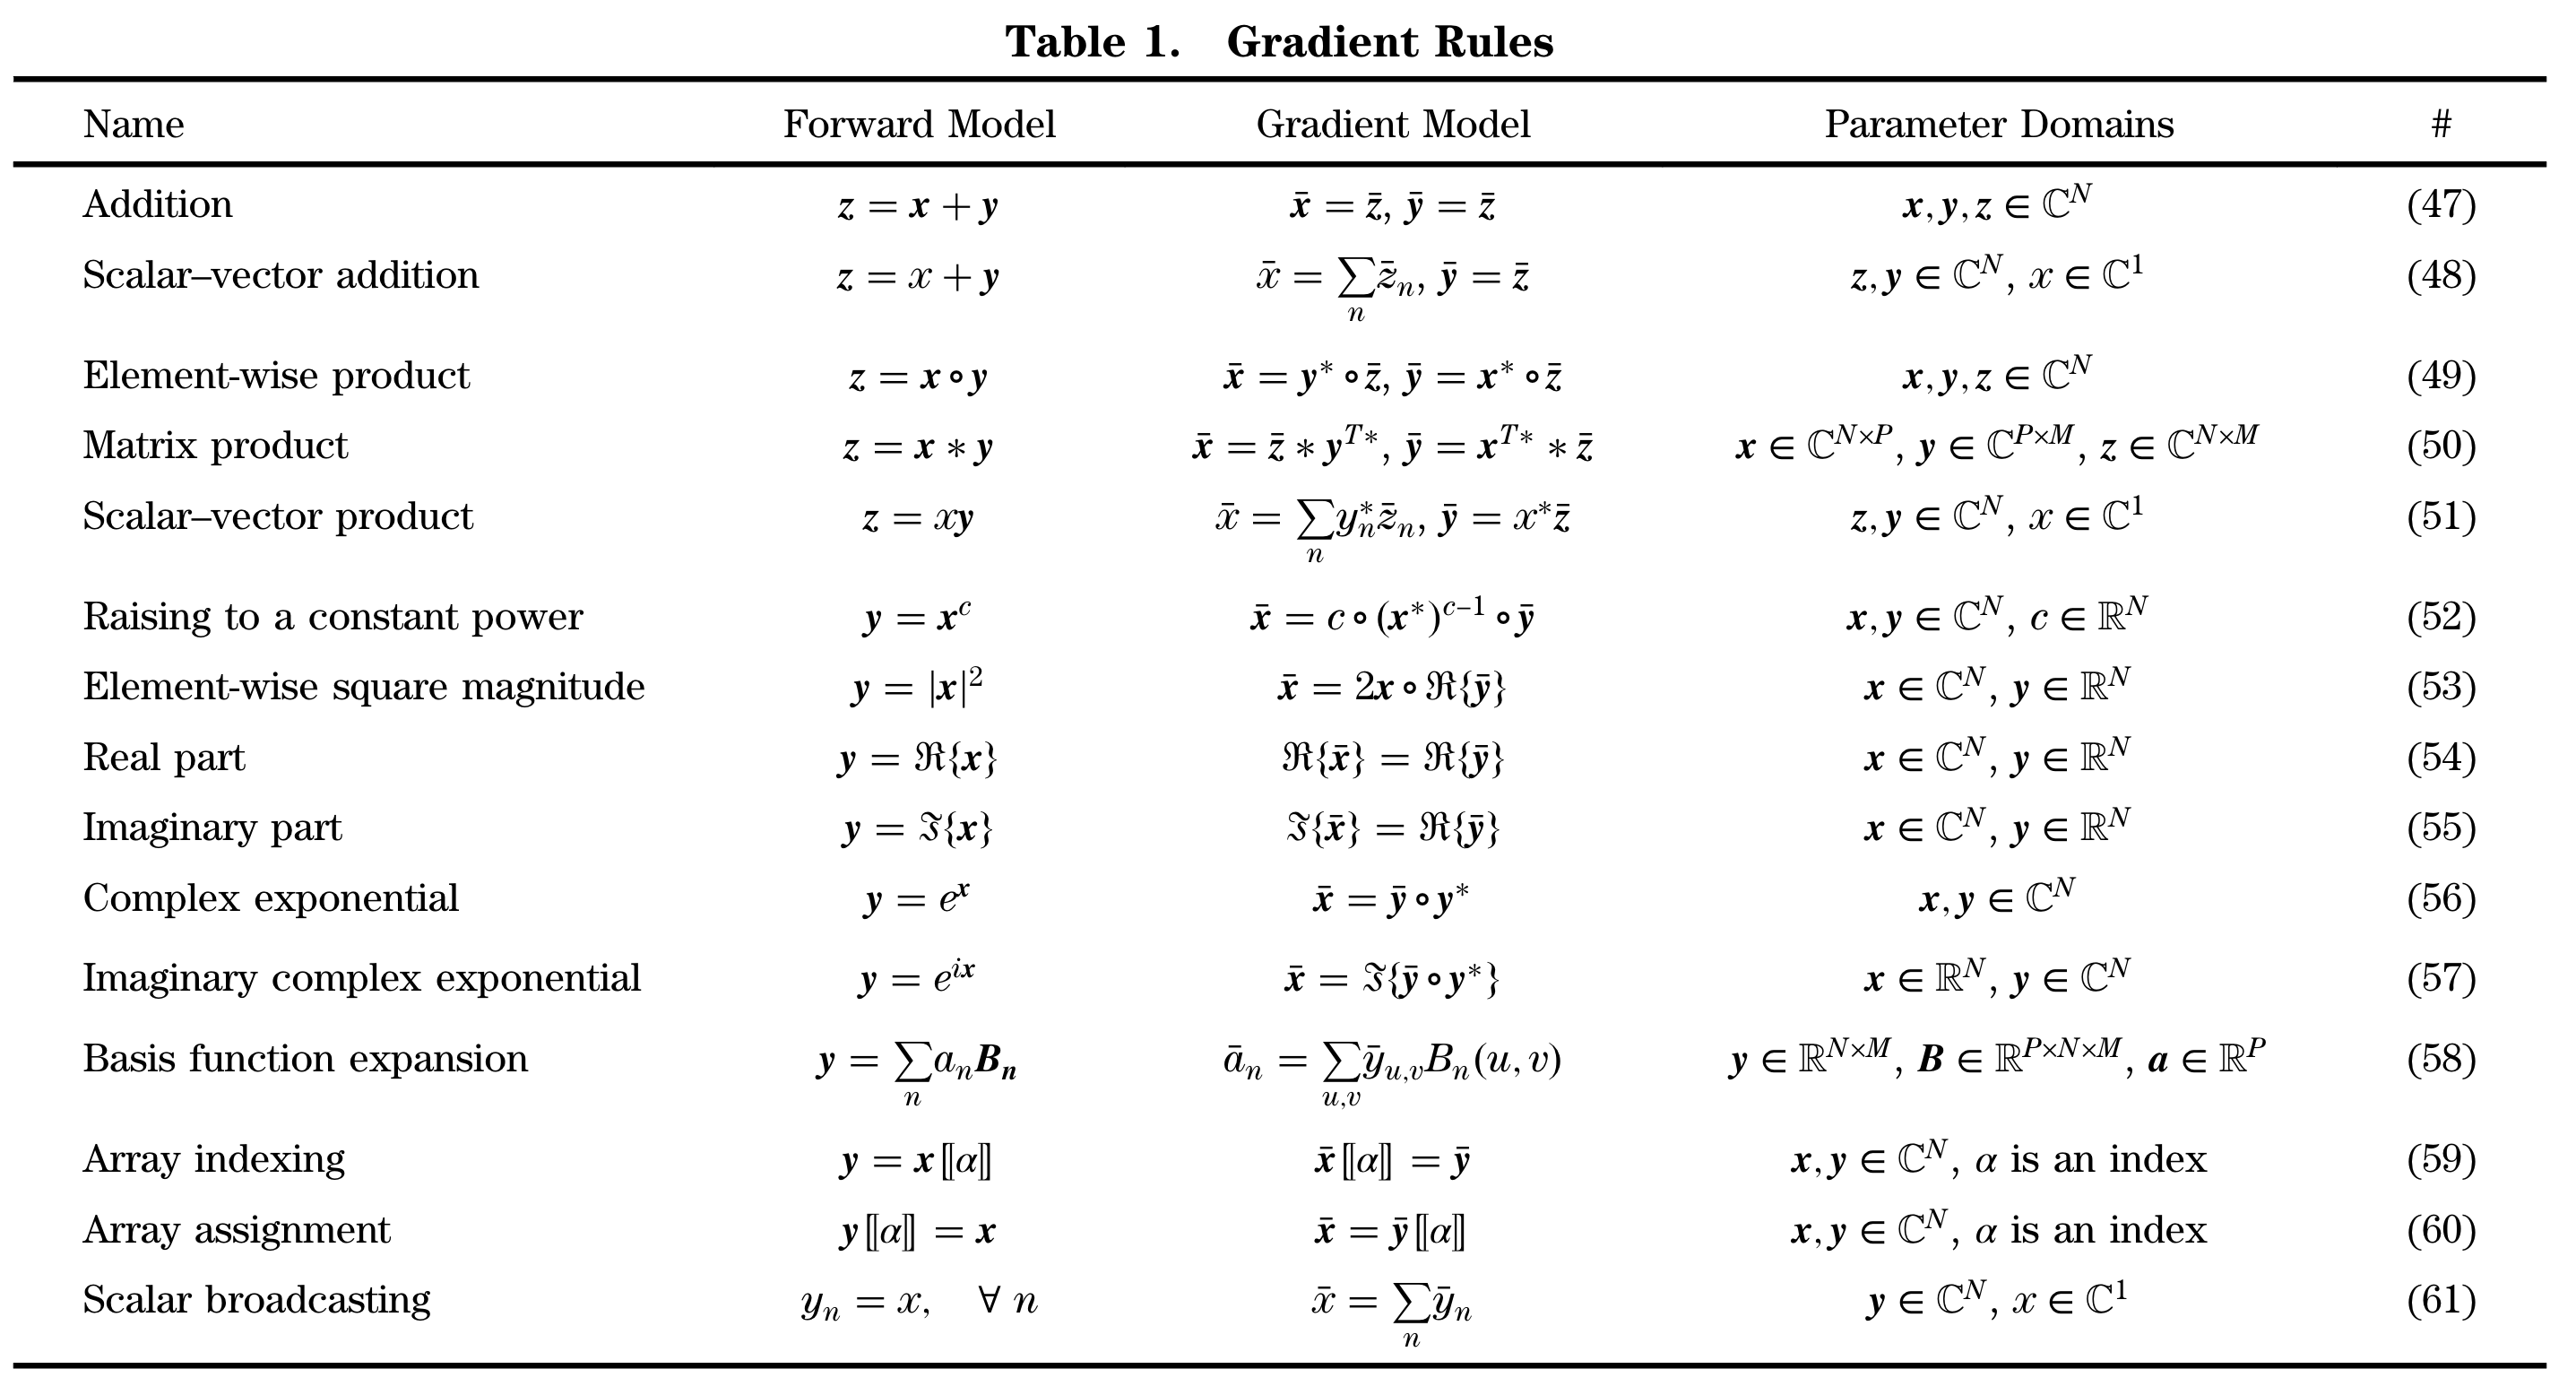

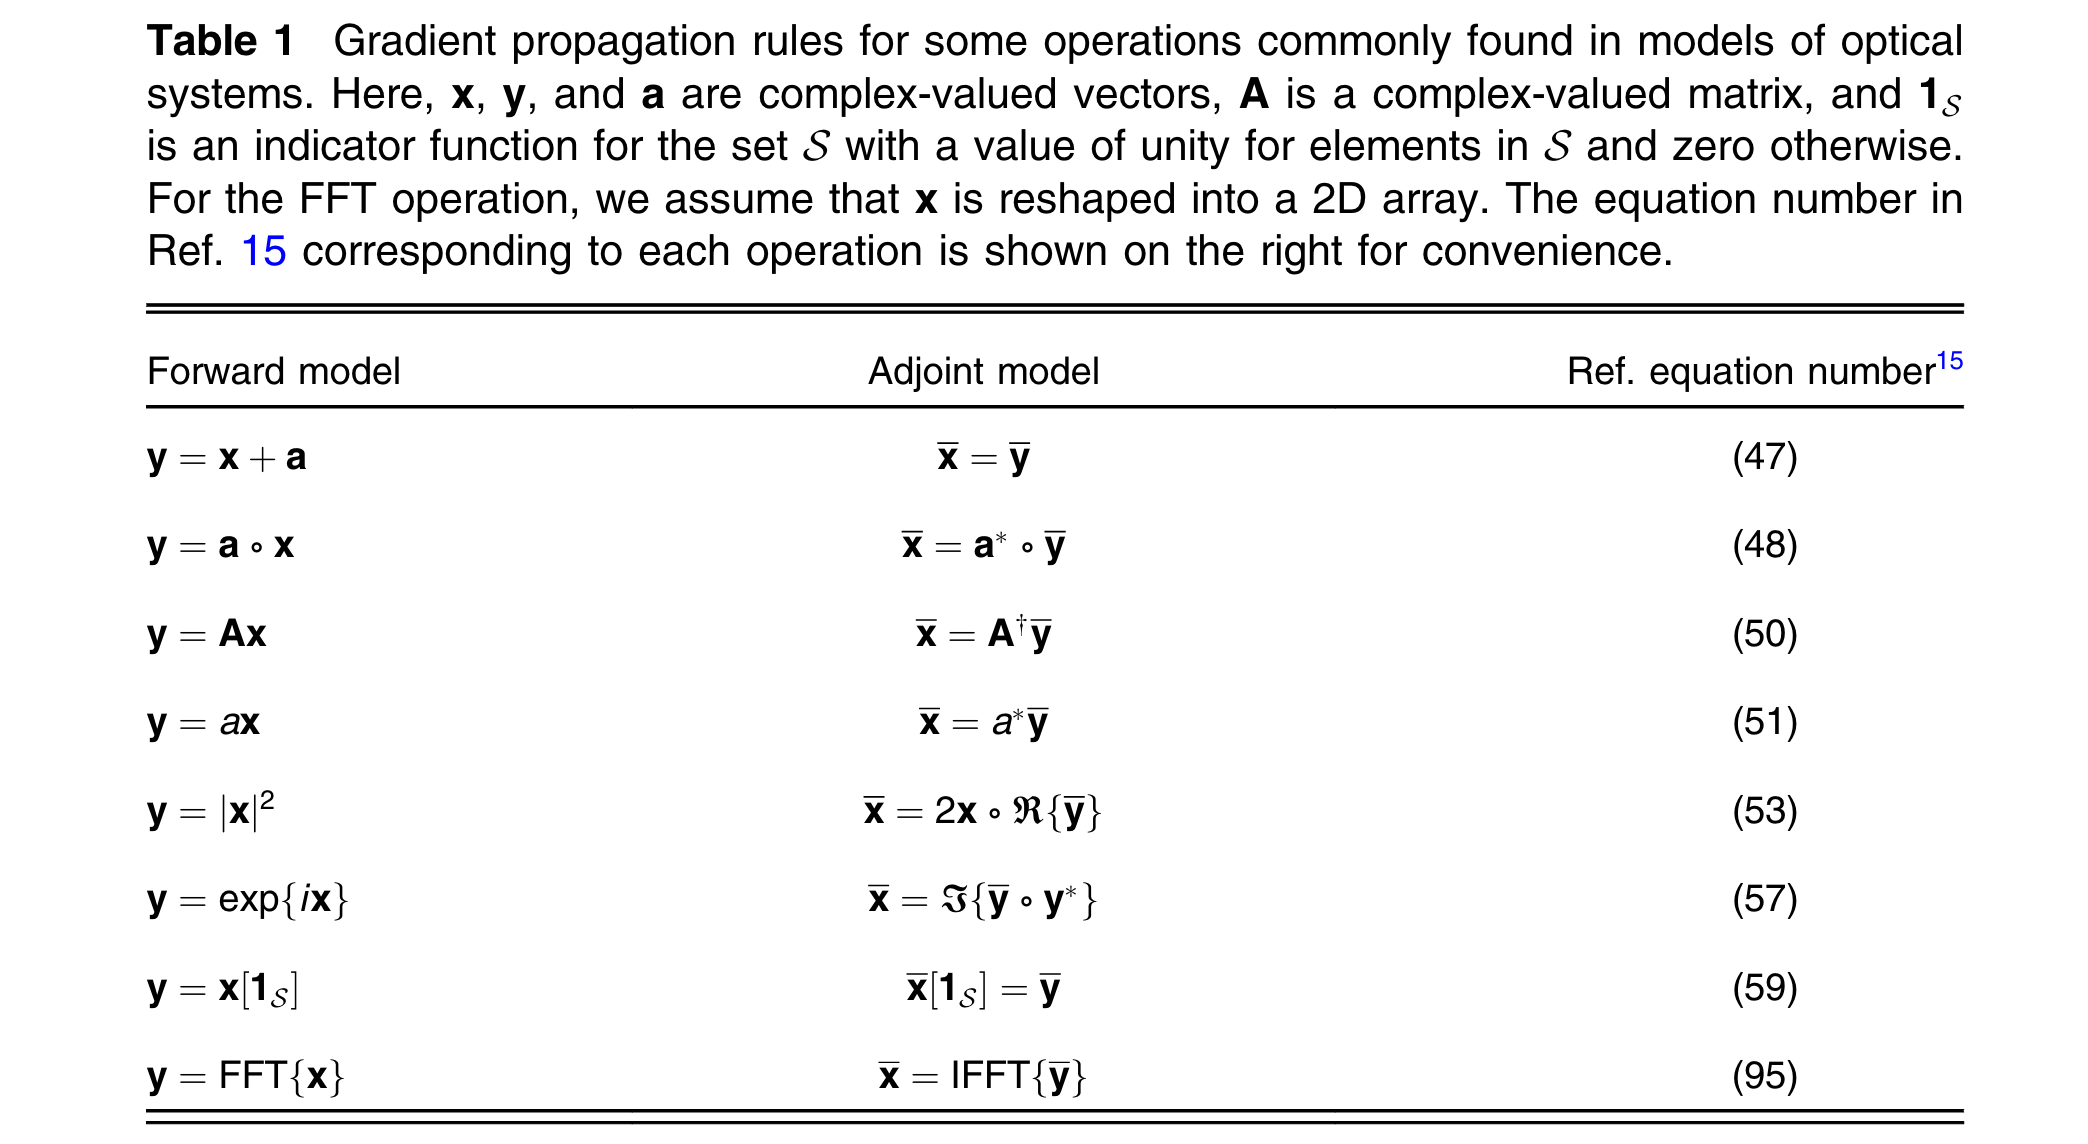

In [ ]:
def compute_cost_fun(actuators, E_ab, E_target=0, r_cond=1e-2):
    Nmask = int(control_mask.sum())
    # Compute E_dm using the forward DM model 
    E_dm = forward_model(actuators)[control_mask] # make sure to do the array indexing

    # I think if I am using WFE, then I need to do two forwad model propagations
    # E_no_dm = forward_model(np.zeros(Nacts), use_wfe=True)
    # E_total = forward_model(actuators, use_wfe=True)
    # E_dm = E_total - E_no_dm

    delE = E_ab + E_dm - E_target
    J_delE = delE.dot(delE.conjugate())
    M_tik = r_cond * xp.eye(Nmask, Nacts)
    c = M_tik.dot(actuators) # how do I construct M_tik?
    J_c = c.dot(c)
    J = J_delE + J_c

    return ensure_np_array(J)

actuators = xp.zeros(Nacts)
J0 = compute_cost_fun(actuators)
print(J0)

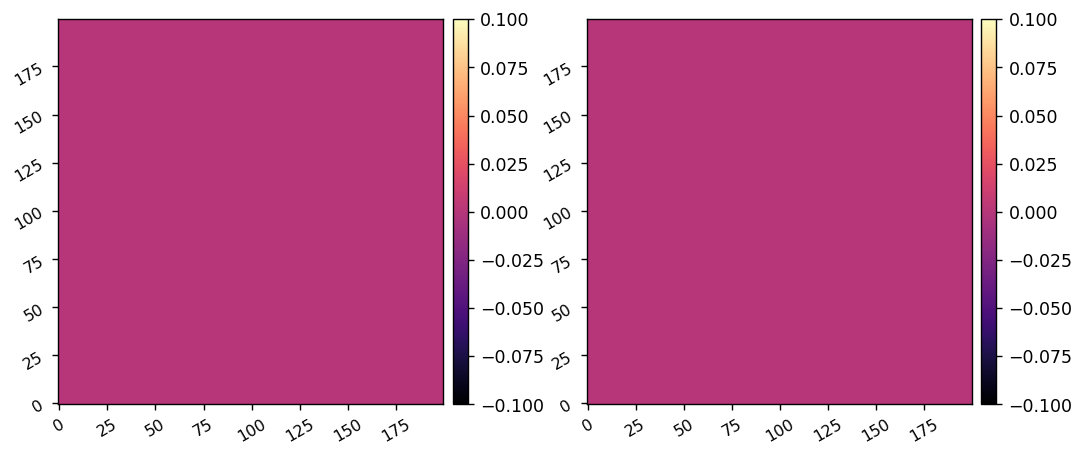

In [95]:
current_acts = np.zeros(Nacts)
del_acts = np.zeros(Nacts)
# del_acts = np.random.randn(Nacts)*1e-9
# del_acts = np.random.randn(Nacts)*1e-12

E_no_dm = forward_model(current_acts, use_wfe=True)/xp.sqrt(I_max_ref)
E_total = forward_model(del_acts, use_wfe=True)/xp.sqrt(I_max_ref)
E_dm = E_total - E_no_dm

imshow2(xp.abs(E_dm)**2, xp.angle(E_dm))

In [145]:
def adjoint_model(del_acts, current_acts, E_ab, E_target=0,):
    E_no_dm = forward_model(current_acts, use_wfe=True)/xp.sqrt(I_max_ref)
    E_total = forward_model(del_acts, use_wfe=True)/xp.sqrt(I_max_ref)
    E_dm = E_total - E_no_dm

    # compute the cost function
    delE = E_ab + E_dm - E_target 
    delE_masked = control_mask * delE

    # compute the gradient with the adjoint model
    dJ_dE_dm = 2 * delE_masked
    dJ_dE_ls = props.mft_reverse(dJ_dE_dm, psf_pixelscale_lamD, nlyot)
    dJ_dE_ls = utils.pad_or_crop(dJ_dE_ls, npix)
    dJ_dE_lp = LYOT * dJ_dE_ls

    # Now we have to split and back-propagate the gradient along the two branches 
    # used to model the vortex. So one branch for the FFT vortex procedure and one 
    # for the MFT vortex procedure. 
    dJ_dE_lp_fft = utils.pad_or_crop(copy.copy(dJ_dE_lp), N_vortex_lres)
    dJ_dE_lp_mft = utils.pad_or_crop(copy.copy(dJ_dE_lp), N_vortex_lres)

    dJ_dE_fpm_fft = xp.fft.fftshift(xp.fft.fft2(xp.fft.ifftshift(dJ_dE_lp_fft)))
    dJ_dE_fp_fft = vortex_lres.conjugate() * (1 - lres_window) * dJ_dE_fpm_fft
    dJ_dE_pup_fft = xp.fft.ifftshift(xp.fft.ifft2(xp.fft.fftshift(dJ_dE_fp_fft)))
    dJ_dE_pup_fft = utils.pad_or_crop(dJ_dE_pup_fft, N)

    dJ_dE_fpm_mft = props.mft_forward(dJ_dE_lp_mft, hres_sampling/oversample_vortex, N_vortex_hres)
    dJ_dE_fp_mft = vortex_hres.conjugate() * hres_window * dJ_dE_fpm_mft
    dJ_dE_pup_mft = props.mft_reverse(dJ_dE_fp_mft, hres_sampling, npix,)
    dJ_dE_pup_mft = utils.pad_or_crop(dJ_dE_pup_mft, N)

    dJ_dE_pup = dJ_dE_pup_fft + dJ_dE_pup_mft

    dJ_dS_dm = 4*xp.pi / wavelength.to_value(u.m) * xp.imag(E_pup.conjugate() * dJ_dE_pup)
    # return dJ_dS_dm

    # Now pad back to the array size fo the DM surface to back propagate through the adjoint DM model
    dJ_dS_dm = utils.pad_or_crop(dJ_dS_dm, Nsurf) 
    x1_bar = fourier_inf_fun.conjugate() * xp.fft.fft2(dJ_dS_dm)
    dJ_dA = Mx_dm_back@x1_bar@My_dm_back / xp.sum(xp.abs(Mx_dm_back))**2

    return ensure_np_array(dJ_dA).real



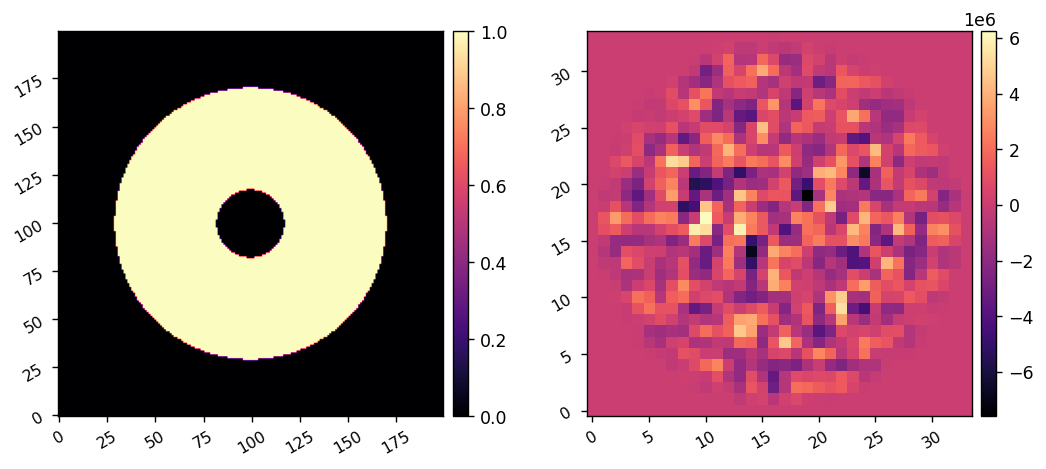

In [160]:
control_mask = create_control_mask(iwa=3, owa=12, edge=None, rotation=0)

current_acts = np.zeros(Nacts)
del_acts = np.zeros(Nacts)
E_ab = coro_wf * control_mask

dJ_dA = adjoint_model(del_acts, current_acts, E_ab, E_target=0,)
imshow2(control_mask, dJ_dA.real)


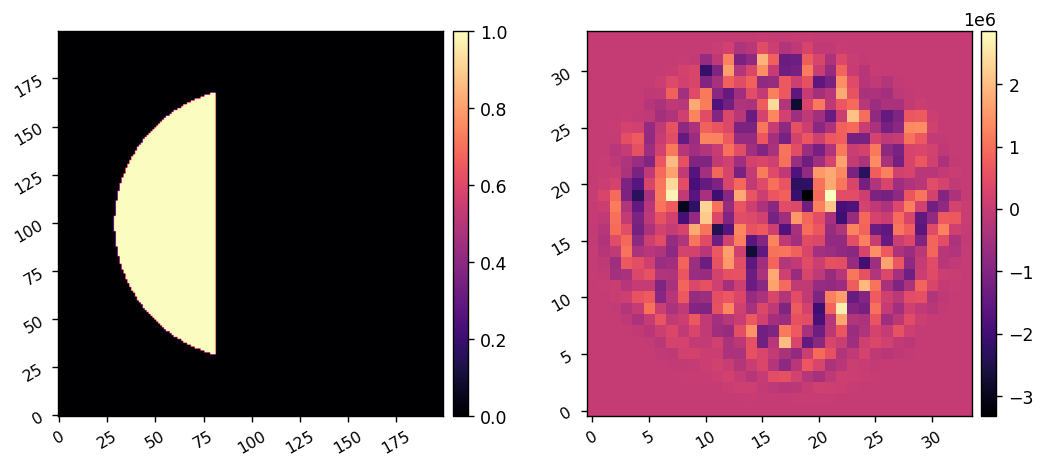

In [163]:
control_mask = create_control_mask(iwa=3, owa=12, edge=3, rotation=180)

current_acts = np.zeros(Nacts)
del_acts = np.zeros(Nacts)
E_ab = coro_wf * control_mask

dJ_dA = adjoint_model(del_acts, current_acts, E_ab, E_target=0,)
imshow2(control_mask, dJ_dA.real)


# Test the generation of EFC probes with the adjoint model. 

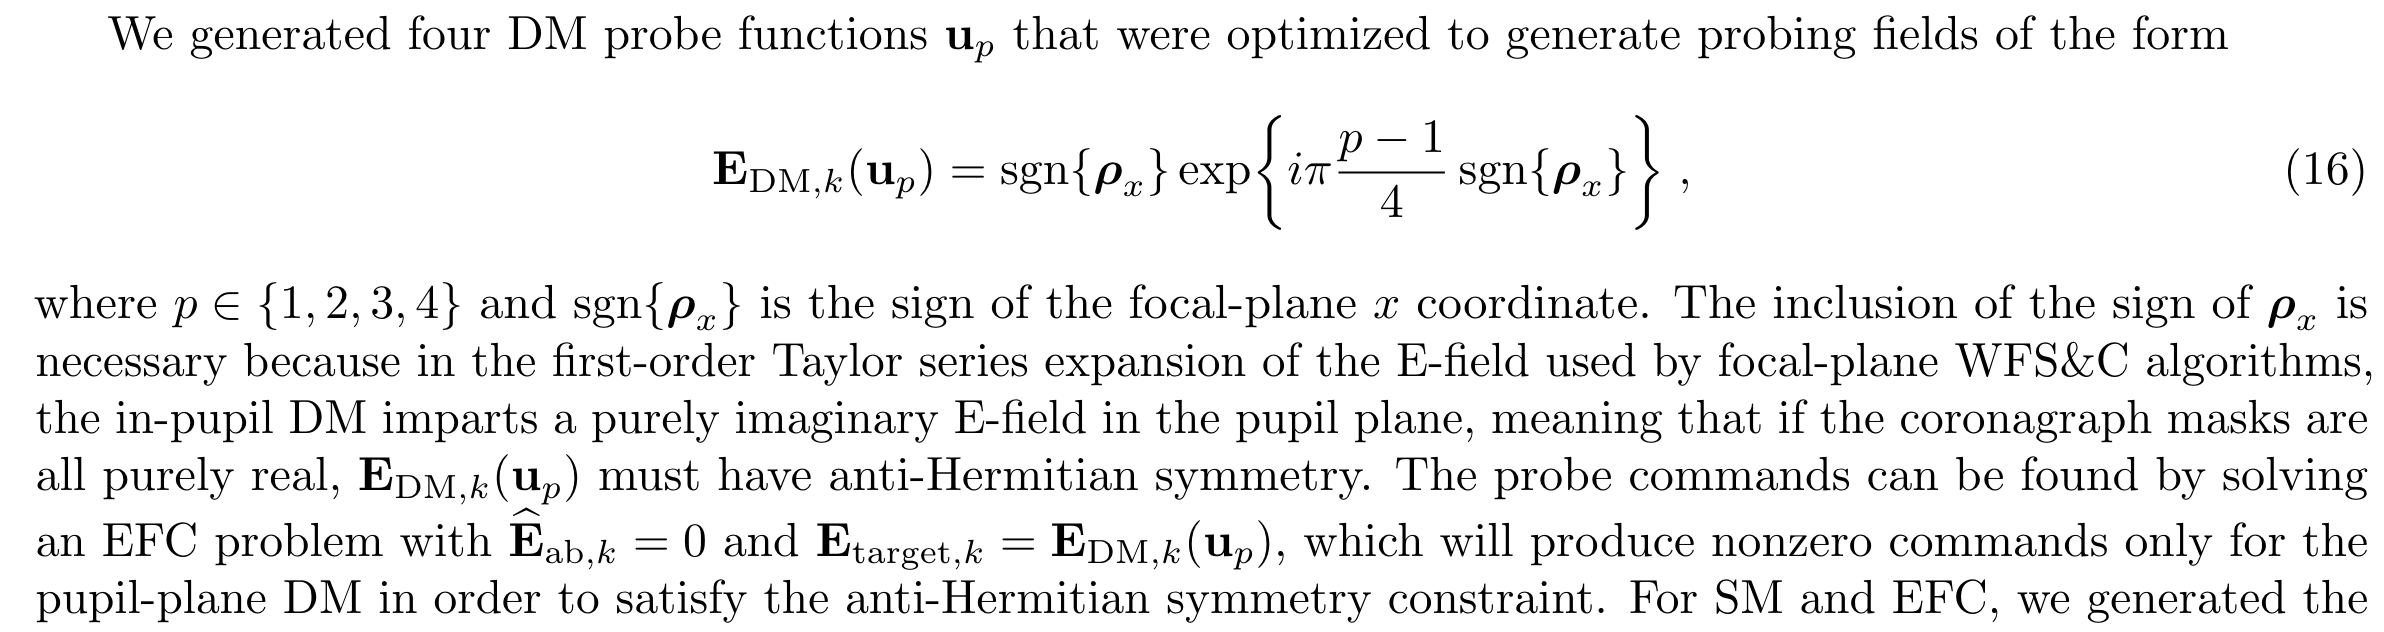

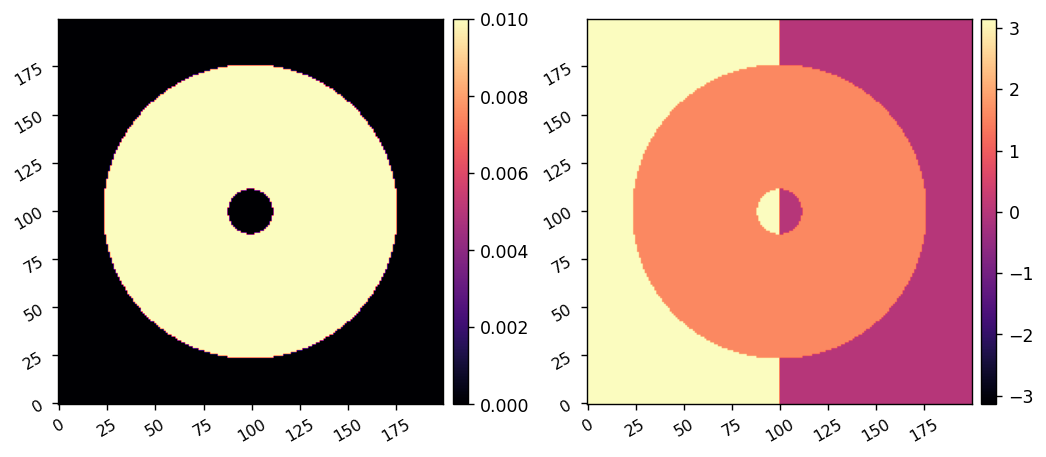

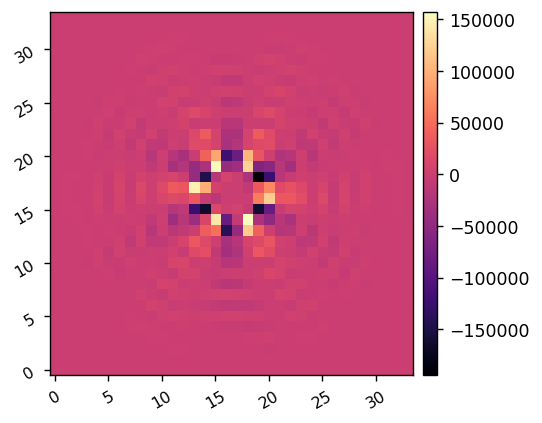

In [184]:
p = 3
control_mask = create_control_mask(iwa=2, owa=13, edge=None, rotation=180)

x = (xp.linspace(-npsf/2, npsf/2-1, npsf) + 1/2)*psf_pixelscale_lamD
px,py = xp.meshgrid(x,x)
E_dm_probe = 1e-2 * xp.sign(px) * xp.exp(1j * xp.pi * (p-1)/4 * xp.sign(px)) * control_mask
imshow2(xp.abs(E_dm_probe), xp.angle(E_dm_probe), vmin2=-np.pi, vmax2=np.pi)

current_acts = np.zeros(Nacts)
del_acts = np.zeros(Nacts)
E_ab = 0
E_target = E_dm_probe

dJ_dA = adjoint_model(del_acts, current_acts, E_ab, E_target=E_target,)
imshow1(dJ_dA.real)